# Aggregate classified hydrometeor from 15 min to 1 hour product
* 1. Check results from classified of 15 min
* 2. Seperate solid class and liqid class by recoding
* 3. Aggregate to be one hour for solid class as hereafter "Hail class" 

In [1]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import numpy as np

In [2]:
# Path to the directory containing your raster files
in_path = './0output/0geotif_cappi/'

# List of input raster files
input_files = ['202004231200.tif', '202004231215.tif', '202004231230.tif', '202004231245.tif']


## 1. Check results from classified of 15 min

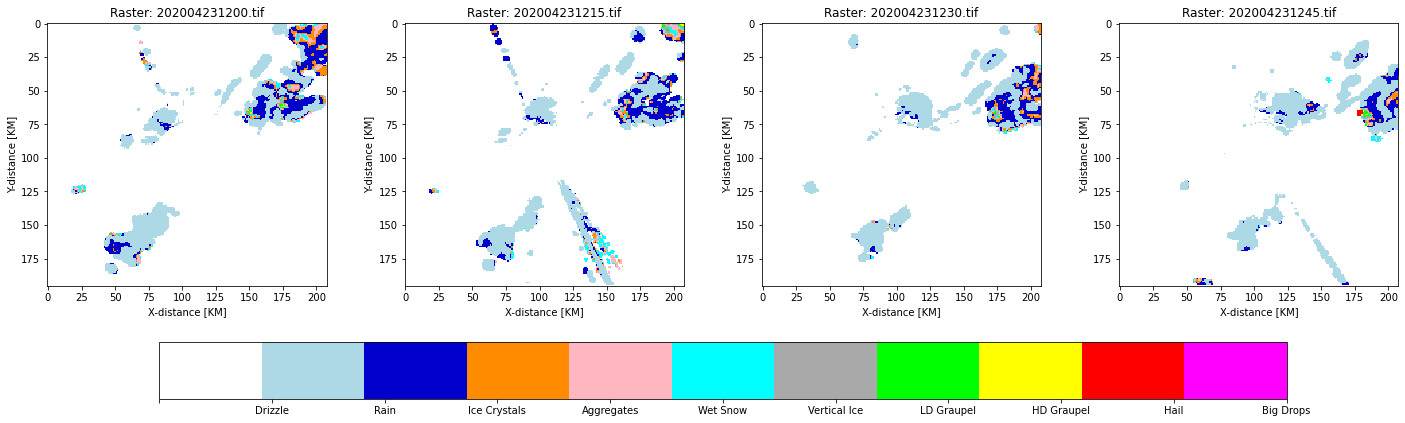

In [3]:
# Define a custom colormap with multiple colors
colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
          'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmap = ListedColormap(colors)

# Names for the tick labels on the color bar
tick_labels = ['','Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
               'Wet Snow', 'Vertical Ice', 'LD Graupel',
               'HD Graupel', 'Hail', 'Big Drops']

# Create a new figure to contain all plots in one row
plt.figure(figsize=(20, 6))

# Process and plot each raster file
for i, input_file in enumerate(input_files):
    with rasterio.open(in_path + input_file) as src:
        raster_data = src.read(1)
        
        # Plot the raster on the current subplot
        plt.subplot(1, len(input_files), i + 1)
        plot = plt.imshow(raster_data, cmap=cmap, interpolation='none', vmin=0, vmax=len(colors)-1)  # Set the range
        plt.title(f'Raster: {input_file}')
        plt.xlabel('X-distance [KM]')
        plt.ylabel('Y-distance [KM]')

# Adjust layout to provide space for the colorbar
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Add a horizontal colorbar at the bottom
cbar = plt.colorbar(plot, ax=plt.gcf().axes, orientation='horizontal', ticks=range(len(tick_labels)))
cbar.ax.set_xticklabels(tick_labels)  # Assign labels to the colorbar ticks

# Display the row of plots with colorbar
plt.show()

## 2.Seperate solid class and liqid class by recoding

* Class 1-2 Grouped to 0 as liquid class
* Class > 2 Grouped to 1 as solid class

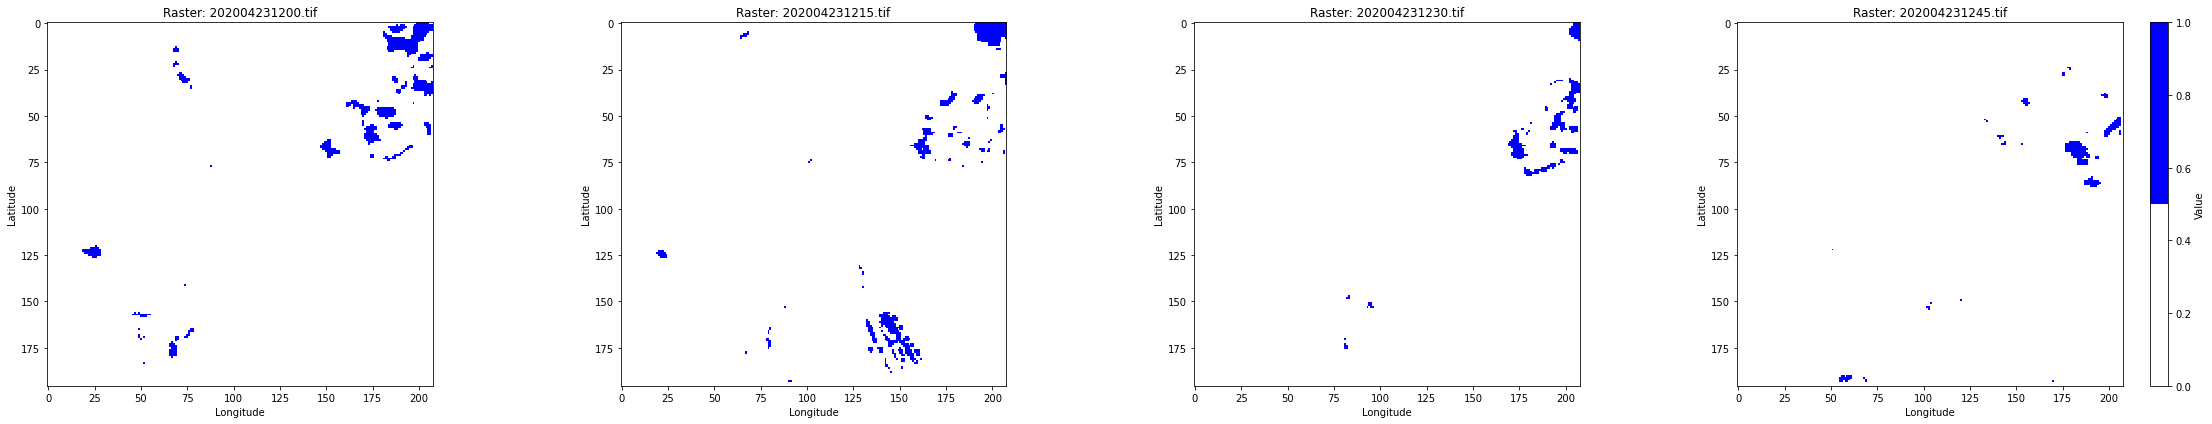

In [4]:
# Define a custom colormap for 0s and 1s
colors = ['white', 'blue']  # white for 0, blue for 1
cmap = ListedColormap(colors)

# Create a ScalarMappable object for the colorbar
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # Important: Set an empty array

# Load and process each raster file
processed_rasters = []
for input_file in input_files:
    with rasterio.open(in_path + input_file) as src:
        raster_data = src.read(1)
        
        # Define recode condition for the current raster
        condition = (raster_data > 2)
        
        # Recode the raster
        recoded_data = np.where(condition, 1, 0)
        processed_rasters.append(recoded_data)

# Create a figure with multiple subplots
num_plots = len(processed_rasters)
fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 8, 6))

# Plot the each processed rasters
for i, (raster_data, input_file) in enumerate(zip(processed_rasters, input_files)):
    with rasterio.open(in_path + input_file) as src:
        transform = src.transform

        # Plot the raster on the current subplot
        ax = axes[i]
        im = ax.imshow(raster_data, cmap=cmap, interpolation='none', vmin=0, vmax=1)
        ax.set_title(f'Raster: {input_file}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Add the colorbar to the last subplot
        if i == num_plots - 1:
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Value')

plt.tight_layout()
plt.show()

## 3.Aggregate to be one hour for solid class as hereafter "Hail class"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


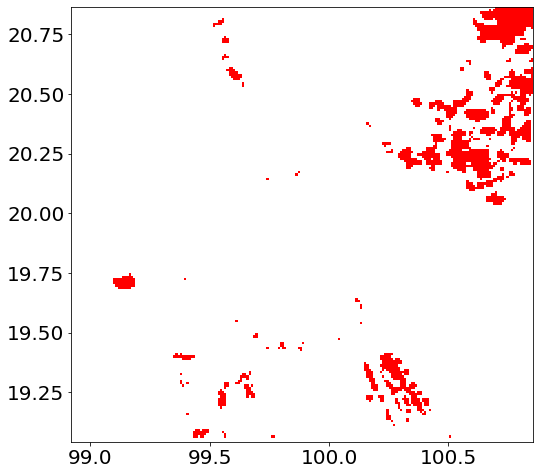

In [5]:
# Define a custom colormap for 0s and 1s
colors = ['white', 'red']  # white for 0, red for 1
cmap = ListedColormap(colors)

# Load and process each raster file
processed_rasters = []
for input_file in input_files:
    with rasterio.open(in_path + input_file) as src:
        raster_data = src.read(1)
        
        # Define recode condition for the current raster
        condition = (raster_data > 2)
        
        # Recode the raster
        recoded_data = np.where(condition, 1, 0)
        processed_rasters.append(recoded_data)

# Combine the recoded rasters based on conditions
combined_data = np.sum(processed_rasters, axis=0).astype(np.uint8)

# Apply a new condition for final recoding
new_condition = (combined_data > 0)
recoded_comb = np.where(new_condition, 1, 0)

# Get the raster metadata from the first processed raster
with rasterio.open(in_path + input_files[0]) as src:
    rows, cols = src.shape
    transform = src.transform
    crs = src.crs

# Define the output file path and save the combined raster
output_path = in_path + '2020042312.tif'
with rasterio.open(output_path, 'w', driver='GTiff', width=cols, height=rows,
                   count=1, dtype=np.uint8, crs=crs, transform=transform) as dst:
    dst.write(recoded_comb, 1) 

    
# Plot the combined raster as a map
plt.figure(figsize=(10, 8))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)    
show(recoded_comb, transform=transform, cmap=cmap, interpolation='none', vmin=0, vmax=1)
plt.show()

We will use the hail product in GEE by uploading these products as GeoTIFF to Asset 